In [1]:
import gpytorch
import torch
import matplotlib.pyplot as plt
import linear_operator

In [128]:
x1 = torch.linspace(0, 1, steps = 10).unsqueeze(-1)
x2 = torch.linspace(10, 100, steps = 10).unsqueeze(-1)
x = torch.cat([x1, x2], dim = -1)

covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernelGrad(ard_num_dims = 2, lengthscale_constraint = gpytorch.constraints.GreaterThan(1e-5)))
covar_module.base_kernel.lengthscale = torch.tensor([1.0, 1.5])
covar = covar_module(x)

In [129]:
covar.to_dense()[0:3, 0:3]

tensor([[0.69, 0.00, 0.00],
        [0.00, 0.69, 0.00],
        [0.00, 0.00, 0.31]], grad_fn=<SliceBackward0>)

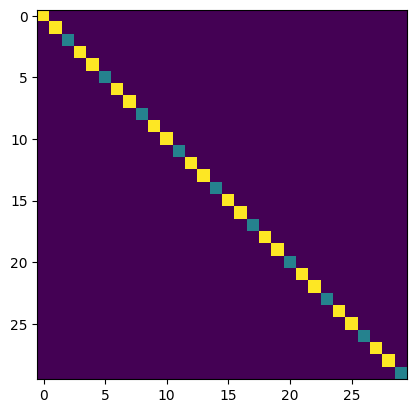

In [ ]:
plt.imshow(covar.to_dense().detach().numpy(), cmap = 'viridis')

In [ ]:
x1 = x
x2 = x[0:9]

batch_shape = x1.shape[:-2]
# 0 if only 2D
print(batch_shape)
N, d = x1.shape[-2:]
# d must be same
n2 = x2.shape[-2]
print(N, n2, d)

# Initialises K: torch.Size([30, 27])
K = torch.zeros(*batch_shape, n1 * (d + 1), n2 * (d + 1), device = x1.device, dtype = x1.dtype)

l1 = 0.5
l2 = 1.0

lengthscale = torch.tensor([l1, l2], device=x1.device, dtype=x1.dtype)

# Each dim is scaled by it's represctive lengthscale
x1_ = x1.div(lengthscale)
x2_ = x2.div(lengthscale)

# outer[:, :, 0] are x1-x1'/l1
# outer[:, :, 1] are x2-x2'/l2
outer = x1_.view(*batch_shape, n1, 1, d) - x2_.view(*batch_shape, 1, n2, d) # torch.Size([10, 9, 2])
# manual = (x1[:, 0].unsqueeze(-1) - x2[:, 0].unsqueeze(0)).div(l1)
# manual == outer[:, :, 0]  # torch.Size([10, 9])

# lengthscale.unsqueeze(-2): torch.Size([1, 2])
# torch.Size([10, 9, 2]) now x1-x1'/l1/l1
outer = outer / lengthscale.unsqueeze(-2)
# torch.Size([10, 2, 9]) N, D, M : swops last two dims
outer_now = torch.transpose(outer, -1, -2).contiguous()

# 1) Kernel block
from gpytorch.kernels.rbf_kernel import postprocess_rbf, RBFKernel
RBFKernel = gpytorch.kernels.RBFKernel(ard_num_dims = 2, lengthscale_constraint = gpytorch.constraints.GreaterThan(1e-5))
# function from RBF class
diff = RBFKernel.covar_dist(x1_, x2_, square_dist = True, lengthscale = lengthscale)
K_11 = postprocess_rbf(diff)
# blockwise assignment
K[..., :N, :n2] = K_11

# 2) First gradient block (uv)
outer1 = outer.view(*batch_shape, N, n2 * d)
# where does n_batch_dims come from?
n_batch_dims = len(batch_shape)
# x1 = x
x2 = x[0:9]

batch_shape = x1.shape[:-2]
# 0 if only 2D
print(batch_shape)
N, d = x1.shape[-2:]
# d must be same
n2 = x2.shape[-2]
print(N, n2, d)

# Initialises K: torch.Size([30, 27])
K = torch.zeros(*batch_shape, n1 * (d + 1), n2 * (d + 1), device = x1.device, dtype = x1.dtype)

l1 = 0.5
l2 = 1.0

lengthscale = torch.tensor([l1, l2], device=x1.device, dtype=x1.dtype)

# Each dim is scaled by it's represctive lengthscale
x1_ = x1.div(lengthscale)
x2_ = x2.div(lengthscale)

# outer[:, :, 0] are x1-x1'/l1
# outer[:, :, 1] are x2-x2'/l2
outer = x1_.view(*batch_shape, n1, 1, d) - x2_.view(*batch_shape, 1, n2, d) # torch.Size([10, 9, 2])
# manual = (x1[:, 0].unsqueeze(-1) - x2[:, 0].unsqueeze(0)).div(l1)
# manual == outer[:, :, 0]  # torch.Size([10, 9])

# lengthscale.unsqueeze(-2): torch.Size([1, 2])
# torch.Size([10, 9, 2]) now x1-x1'/l1^2
outer = outer / lengthscale.unsqueeze(-2)
# torch.Size([10, 2, 9]) N, D, M : swops last two dims
outer = torch.transpose(outer, -1, -2).contiguous()

# 1) Kernel block
from gpytorch.kernels.rbf_kernel import postprocess_rbf, RBFKernel
RBFKernel = gpytorch.kernels.RBFKernel(ard_num_dims = 2, lengthscale_constraint = gpytorch.constraints.GreaterThan(1e-5))
# function from RBF class
diff = RBFKernel.covar_dist(x1_, x2_, square_dist = True, lengthscale = lengthscale)
K_11 = postprocess_rbf(diff)
# blockwise assignment
K[..., :n1, :n2] = K_11

# 2) First gradient block (uv)
outer1 = outer.view(*batch_shape, n1, n2 * d)
# where does n_batch_dims come from?
n_batch_dims = len(batch_shape)
# torch.Size([10, 18]) 
K[..., :n1, n2:] = outer1 * K_11.repeat([*([1] * (n_batch_dims + 1)), d])
# (outer1 * K_11.repeat([*([1] * (n_batch_dims + 1)), d])).shape

# 3) Second gradient block (vu)
outer2 = outer.transpose(-1, -3).reshape(*batch_shape, n2, n1 * d)
outer2 = outer2.transpose(-1, -2)
# torch.Size([20, 9]) lower left (tall)
K[..., n1:, :n2] = -outer2 * K_11.repeat([*([1] * n_batch_dims), d, 1])
# (-outer2 * K_11.repeat([*([1] * n_batch_dims), d, 1])).shape

# 4) Hessian block (second derivates)
# torch.Size([20, 18]) & torch.Size([20, 18])
outer3 = outer1.repeat([*([1] * n_batch_dims), d, 1]) * outer2.repeat([*([1] * (n_batch_dims + 1)), d])
# torch.Size([20, 18])
# first torch.Size([10, 9]) block is just filled with 1/l1**2
# second (top right) torch.Size([10, 9]) block is zeros
# third (bottom left) torch.Size([10, 9]) block is zeros
# fourth (bottom right) torch.Size([10, 9]) block is filled with 1/l2**2
kp = linear_operator.operators.KroneckerProductLinearOperator(
                # [(1/l1^2), 0][0, 1/l2^2]
                torch.eye(d, d, device=x1.device, dtype=x1.dtype).repeat(*batch_shape, 1, 1) / lengthscale.pow(2),
                # torch.Size([10, 9]) filled with ones
                torch.ones(n1, n2, device=x1.device, dtype=x1.dtype).repeat(*batch_shape, 1, 1),
            )

# 1 /l1**2 - outer3
# torch.Size([20, 18]) with 4 big blocks
chain_rule = kp.to_dense() - outer3
torch.set_printoptions(precision=2, sci_mode=False)
# elementswise mul torch.Size([20, 18])
K[..., n1:, n2:] = chain_rule * K_11.repeat([*([1] * n_batch_dims), d, d])

torch.Size([])
10 9 2
torch.Size([])
10 9 2


torch.Size([20, 18])

# draft my own

In [ ]:
import torch
from linear_operator.operators import KroneckerProductLinearOperator
from gpytorch.kernels.rbf_kernel import postprocess_rbf, RBFKernel


class dfRBFKernel(RBFKernel):
    r"""
    Computes a divergence-free RBF covariance matrix of the RBF kernel that models the covariance
    for inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`. The code is heavily based on the Hessian component of the RBF grad kernel, also inheriting from Gpytorch's RBF kernel (see source code here: https://docs.gpytorch.ai/en/stable/_modules/gpytorch/kernels/rbf_kernel_grad.html#RBFKernelGrad) to enable computational speed ups.

    Notes: 
    - This only works for 2D currently. 
    - Uses self.lengthscale object.

    See :class:`gpytorch.kernels.Kernel` for descriptions of the lengthscale options.

    .. note::

        This kernel does not have an `outputscale` parameter. To add a scaling parameter,
        decorate this kernel with a :class:`gpytorch.kernels.ScaleKernel`.

    :param ard_num_dims: Set this if you want a separate lengthscale for each input
        dimension. It should be `d` if x1 is a `n x d` matrix. (Default: `None`.)
    :param batch_shape: Set this if you want a separate lengthscale for each batch of input
        data. It should be :math:`B_1 \times \ldots \times B_k` if :math:`\mathbf x1` is
        a :math:`B_1 \times \ldots \times B_k \times N \times D` tensor.
    :param active_dims: Set this if you want to compute the covariance of only
        a few input dimensions. The ints corresponds to the indices of the
        dimensions. (Default: `None`.)
    :param lengthscale_prior: Set this if you want to apply a prior to the
        lengthscale parameter. (Default: `None`)
    :param lengthscale_constraint: Set this if you want to apply a constraint
        to the lengthscale parameter. (Default: `Positive`.)
    :param eps: The minimum value that the lengthscale can take (prevents
        divide by zero errors). (Default: `1e-6`.)

    :ivar torch.Tensor lengthscale: The lengthscale parameter. Size/shape of parameter depends on the
        ard_num_dims and batch_shape arguments.

    Example:
        >>> x = torch.randn(10, 2)
        >>> # Non-batch: Simple option
        >>> covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.dfRBFKernel())
        >>> covar = covar_module(x)  # Output: LinearOperator of size (20 x 20), where 20 = n * d
    """

    def forward(self, x1, x2, diag = False, **params):

        ### STEP 1: EXTRACT BATCHES & DIMS ###

        # BATCHES
        # NOTE: We write this in a batch compatible way, using negative indexing (from the right)
        # batch_shape is torch.Size([]) if only 2D
        batch_shape = x1.shape[:-2]
        # usually zero, one, or two
        n_batch_dims = len(batch_shape)

        # DIMS
        N, d = x1.shape[-2:]
        # d must be same
        M = x2.shape[-2]

        # We save compute when diag = True by only computing what is needed
        if not diag:

            ### STEP 2: DIRECTIONAL SCALED DIFFERENCES ###
            # Scale the inputs by the lengthscale(s) (e.g. two lengthscales if ard_num_dims = 2)
            # HACK: Applying div before subtracting increases stability
            x1_ = x1.div(self.lengthscale)
            x2_ = x2.div(self.lengthscale)

            # Broadcast and compute directional (scaled) differences (..., N, M, d)
            directional_scaled_diffs = x1_.view(*batch_shape, N, 1, d) - x2_.view(*batch_shape, 1, M, d)
            # Divide by lengthscales again to get directional_scaled_diffs: (x1 - x2) / ℓ^2
            # lengthscale e.g. shape (1, 2) (unsqueeze to broadcast)
            directional_scaled_diffs = directional_scaled_diffs / self.lengthscale.unsqueeze(-2)

            # HACK: Flip the last axis to have d2, d1 ordering. The off-diagonals thus remain the same while the diagonals are flipped. This is new for the dfRBF kernel.
            directional_scaled_diffs = torch.flip(directional_scaled_diffs, dims = [-1])

            # (..., N, d, M): swops last two dims
            directional_scaled_diffs = torch.transpose(directional_scaled_diffs, -1, -2).contiguous()

            # torch.Size([..., N, d * M]) where the first M indices are d1 and the latter M indices are d2 for 2d
            # d1 diffs are the left block, d2 diffs are the right block
            directional_scaled_diffs_N_rows_wide = directional_scaled_diffs.view(*batch_shape, N, d * M)
            
            # transpose swop N and M so makes torch.Size([..., M, d, N])
            # reshape torch.Size([..., M, d * N])
            directional_scaled_diffs_M_rows_wide = directional_scaled_diffs.transpose(-1, -3).reshape(*batch_shape, M, d * N)
            # d1 diffs are the upper block, d2 diffs are the lower block
            directional_scaled_diffs_2N_rows_tall = directional_scaled_diffs_M_rows_wide.transpose(-1, -2)

            # 1) Kernel block
            # NOTE: as an instance of the RBF kernel, we can use the covar_dist method to compute the squared distance;
            # This uses our lengthscale.
            diff = self.covar_dist(x1_, x2_, square_dist = True, **params)
            # torch.Size([..., N, M])
            K_rbf = postprocess_rbf(diff)

            ### STEP 4: BLOCKWISE ASSIGNMENTS ###
            # torch.Size([..., N * d, M * d])
            # First term: Last axis stays the same, second last axis (rows) is repeated
            directional_scaled_diffs_two_rows = directional_scaled_diffs_N_rows_wide.repeat([*([1] * n_batch_dims), d, 1]) 
            # Second term: Last axis (columns) is repeated, second last axis (rows) stays the same
            directional_scaled_diffs_two_columns = directional_scaled_diffs_2N_rows_tall.repeat([*([1] * (n_batch_dims + 1)), d])

            # Upper left is r_1**2/l_1**4
            # Upper right and lower left are r_1 * r_2 / (l_1**2 * l_2**2)
            # Lower right is r_2**2 / l_2**4
            directional_scaled_diffs_product_block = directional_scaled_diffs_two_rows * directional_scaled_diffs_two_columns

            ### STEP 5: SIGN BLOCK ###
            # Create sign block to negate off-diagonal blocks
            sign_block = KroneckerProductLinearOperator(
                torch.tensor([[1., -1.], [-1., 1.]], device = x1.device, dtype = x1.dtype).repeat(*batch_shape, 1, 1),
                torch.ones(N, M, device = x1.device, dtype = x1.dtype).repeat(*batch_shape, 1, 1)
            )

            directional_scaled_diffs_product_block = sign_block * directional_scaled_diffs_product_block

            ### STEP 6: KRONECKER PRODUCT BLOCK ###
            # torch.Size([..., N * d, M * d])
            kp = KroneckerProductLinearOperator(
                        # Upper left block is (1/l1^2)
                        # Lower right block is (1/l2^2)
                        # Upper right and lower left blocks are (0)
                        # HACK: Flip the last axis to match the dfRBF ordering. This is another change from the RBF grad kernel.
                        torch.eye(d, d, device = x1.device, dtype = x1.dtype).repeat(*batch_shape, 1, 1) / lengthscale.flip(-1).pow(2),
                        # Expand
                        torch.ones(N, M, device = x1.device, dtype = x1.dtype).repeat(*batch_shape, 1, 1),
                    )
            
            ### STEP 6: SUBTRACT BLOCKS ###
            # Upper left block is (1/l1^2 - product)
            # Lower right block is (1/l2^2 - product)
            # Upper right and lower left blocks are (0 - product), resulting in the negative product
            subtracted_blocks = kp.to_dense() - directional_scaled_diffs_product_block
            # repeat K_rbf d * d times
            K = subtracted_blocks * K_rbf.repeat([*([1] * n_batch_dims), d, d])

            # Symmetrize for stability (Not for K_train_test of course)
            if N == M and torch.eq(x1, x2).all():
                K = 0.5 * (K.transpose(-1, -2) + K)

            # Apply a perfect shuffle permutation to match the MutiTask ordering
            pi1 = torch.arange(N * d).view(d, N).t().reshape((N * d))
            pi2 = torch.arange(M * d).view(d, M).t().reshape((M * d))
            K = K[..., pi1, :][..., :, pi2]

            return K

        # If diag = True, we only compute the diagonal elements
        else:
            if not (N == M and torch.eq(x1, x2).all()):
                raise RuntimeError("diag = True only works when x1 == x2")
            
            # NOTE: We have to flip the last axis of lengthscale to match the dfRBF ordering.
            grad_diag = torch.ones(*batch_shape, M, d, device = x1.device, dtype = x1.dtype) / lengthscale.flip(-1).pow(2)
            grad_diag = grad_diag.transpose(-1, -2).reshape(*batch_shape, M * d)

            # The permutation indices for the diagonal elements to match interleaved format in Multitask settinga
            pi = torch.arange(M * d).view(d, M).t().reshape((M * d))
            return grad_diag[..., pi]

    def num_outputs_per_input(self, x1, x2):
        return x1.size(-1)

# Write only Hessian portion in my language with annotation

In [31]:
### HESSIAN BLOCK ###

import torch
from linear_operator.operators import KroneckerProductLinearOperator
from gpytorch.kernels.rbf_kernel import postprocess_rbf, RBFKernel

x1 = torch.linspace(0, 1, steps = 10).unsqueeze(-1)
x2 = torch.linspace(10, 100, steps = 10).unsqueeze(-1)
x = torch.cat([x1, x2], dim = -1)

x1 = x
# keep indices seperable
x2 = x[0:9]

diag = False
l1 = 0.5 * 5
l2 = 1.0 * 5
lengthscale = torch.tensor([l1, l2], device = x1.device, dtype = x1.dtype)

# BATCHES
# NOTE: We write this in a batch compatible way, using negative indexing (from the right)
# batch_shape is torch.Size([]) if only 2D
batch_shape = x1.shape[:-2]
# usually zero, one, or two
n_batch_dims = len(batch_shape)

# DIMS
N, d = x1.shape[-2:]
# d must be same
M = x2.shape[-2]

# We save compute when diag = True by only computing what is needed
if not diag:

    # K = torch.zeros(*batch_shape, N * d, M * d, device = x1.device, dtype = x1.dtype)

    ### STEP 2: DIRECTIONAL SCALED DIFFERENCES ###
    # Scale the inputs by the lengthscale(s) (e.g. two lengthscales if ard_num_dims = 2)
    # HACK: Applying div before subtracting increases stability
    x1_ = x1.div(lengthscale)
    x2_ = x2.div(lengthscale)

    # Broadcast and compute directional (scaled) differences (..., N, M, d)
    directional_scaled_diffs = x1_.view(*batch_shape, N, 1, d) - x2_.view(*batch_shape, 1, M, d)
    # Divide by lengthscales again to get directional_scaled_diffs: (x1 - x2) / ℓ^2
    # lengthscale e.g. shape (1, 2) (unsqueeze to broadcast)
    directional_scaled_diffs = directional_scaled_diffs / lengthscale.unsqueeze(-2)
    # (..., N, d, M): swops last two dims
    directional_scaled_diffs = torch.transpose(directional_scaled_diffs, -1, -2).contiguous()

    # torch.Size([..., N, d * M]) where the first M indices are d1 and the latter M indices are d2 for 2d
    # d1 diffs are the left block, d2 diffs are the right block
    directional_scaled_diffs_N_rows_wide = directional_scaled_diffs.view(*batch_shape, N, d * M)
    
    # transpose swop N and M so makes torch.Size([..., M, d, N])
    # reshape torch.Size([..., M, d * N])
    directional_scaled_diffs_M_rows_wide = directional_scaled_diffs.transpose(-1, -3).reshape(*batch_shape, M, d * N)
    # d1 diffs are the upper block, d2 diffs are the lower block
    directional_scaled_diffs_2N_rows_tall = directional_scaled_diffs_M_rows_wide.transpose(-1, -2)

    ### STEP 3: RBF BLOCK ###
    RBFKernel = gpytorch.kernels.RBFKernel(ard_num_dims = 2, lengthscale_constraint = gpytorch.constraints.GreaterThan(1e-5))
    diff = RBFKernel.covar_dist(x1_, x2_, square_dist = True, lengthscale = lengthscale)
    # torch.Size([..., N, M])
    K_rbf = postprocess_rbf(diff)

    ### STEP 4: BLOCKWISE ASSIGNMENTS ###
    # torch.Size([..., N * d, M * d])
    # First term: Last axis stays the same, second last axis (rows) is repeated
    directional_scaled_diffs_two_rows = directional_scaled_diffs_N_rows_wide.repeat([*([1] * n_batch_dims), d, 1]) 
    # Second term: Last axis (columns) is repeated, second last axis (rows) stays the same
    directional_scaled_diffs_two_columns = directional_scaled_diffs_2N_rows_tall.repeat([*([1] * (n_batch_dims + 1)), d])

    # Upper left is r_1**2/l_1**4
    # Upper right and lower left are r_1 * r_2 / (l_1**2 * l_2**2)
    # Lower right is r_2**2 / l_2**4
    directional_scaled_diffs_product_block = directional_scaled_diffs_two_rows * directional_scaled_diffs_two_columns

    ### STEP 5: KRONECKER PRODUCT BLOCK ###
    # torch.Size([..., N * d, M * d])
    kp = KroneckerProductLinearOperator(
                # Upper left block is (1/l1^2)
                # Lower right block is (1/l2^2)
                # Upper right and lower left blocks are (0)
                torch.eye(d, d, device = x1.device, dtype = x1.dtype).repeat(*batch_shape, 1, 1) / lengthscale.pow(2),
                # Expand
                torch.ones(N, M, device = x1.device, dtype = x1.dtype).repeat(*batch_shape, 1, 1),
            )
    
    ### STEP 6: SUBTRACT BLOCKS ###
    # Upper left block is (1/l1^2 - product)
    # Lower right block is (1/l2^2 - product)
    # Upper right and lower left blocks are (0 - product), resulting in the negative product
    subtracted_blocks = kp.to_dense() - directional_scaled_diffs_product_block
    # repeat K_rbf d * d times
    K_hess = subtracted_blocks * K_rbf.repeat([*([1] * n_batch_dims), d, d])

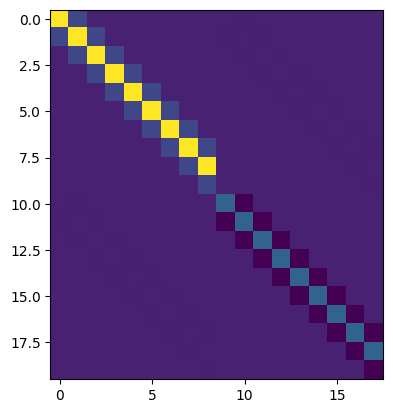

In [34]:
plt.imshow(K_hess.to_dense().detach().numpy(), cmap = 'viridis')

# Make changes to get dfRBF

In [66]:
### dfRBF BLOCK ###

import torch
from linear_operator.operators import KroneckerProductLinearOperator
from gpytorch.kernels.rbf_kernel import postprocess_rbf, RBFKernel

x1 = torch.linspace(0, 1, steps = 10).unsqueeze(-1)
x2 = torch.linspace(10, 100, steps = 10).unsqueeze(-1)
x = torch.cat([x1, x2], dim = -1)

x1 = x
# keep indices seperable
# x2 = x[0:9]
# For diagonal test
x2 = x

diag = False
l1 = 0.5 * 5
l2 = 1.0 * 5
lengthscale = torch.tensor([l1, l2], device = x1.device, dtype = x1.dtype)

# BATCHES
# NOTE: We write this in a batch compatible way, using negative indexing (from the right)
# batch_shape is torch.Size([]) if only 2D
batch_shape = x1.shape[:-2]
# usually zero, one, or two
n_batch_dims = len(batch_shape)

# DIMS
N, d = x1.shape[-2:]
# d must be same
M = x2.shape[-2]

# We save compute when diag = True by only computing what is needed
if not diag:

    # K = torch.zeros(*batch_shape, N * d, M * d, device = x1.device, dtype = x1.dtype)

    ### STEP 2: DIRECTIONAL SCALED DIFFERENCES ###
    # Scale the inputs by the lengthscale(s) (e.g. two lengthscales if ard_num_dims = 2)
    # HACK: Applying div before subtracting increases stability
    x1_ = x1.div(lengthscale)
    x2_ = x2.div(lengthscale)

    # Broadcast and compute directional (scaled) differences (..., N, M, d)
    directional_scaled_diffs = x1_.view(*batch_shape, N, 1, d) - x2_.view(*batch_shape, 1, M, d)
    # Divide by lengthscales again to get directional_scaled_diffs: (x1 - x2) / ℓ^2
    # lengthscale e.g. shape (1, 2) (unsqueeze to broadcast)
    directional_scaled_diffs = directional_scaled_diffs / lengthscale.unsqueeze(-2)

    # HACK: Flip the last axis to have d2, d1 ordering. The off-diagonals thus remain the same while the diagonals are flipped. This is new for the dfRBF kernel.
    directional_scaled_diffs = torch.flip(directional_scaled_diffs, dims = [-1])

    # (..., N, d, M): swops last two dims
    directional_scaled_diffs = torch.transpose(directional_scaled_diffs, -1, -2).contiguous()

    # torch.Size([..., N, d * M]) where the first M indices are d1 and the latter M indices are d2 for 2d
    # d1 diffs are the left block, d2 diffs are the right block
    directional_scaled_diffs_N_rows_wide = directional_scaled_diffs.view(*batch_shape, N, d * M)
    
    # transpose swop N and M so makes torch.Size([..., M, d, N])
    # reshape torch.Size([..., M, d * N])
    directional_scaled_diffs_M_rows_wide = directional_scaled_diffs.transpose(-1, -3).reshape(*batch_shape, M, d * N)
    # d1 diffs are the upper block, d2 diffs are the lower block
    directional_scaled_diffs_2N_rows_tall = directional_scaled_diffs_M_rows_wide.transpose(-1, -2)

    ### STEP 3: RBF BLOCK ###
    RBFKernel = gpytorch.kernels.RBFKernel(ard_num_dims = 2, lengthscale_constraint = gpytorch.constraints.GreaterThan(1e-5))
    diff = RBFKernel.covar_dist(x1_, x2_, square_dist = True, lengthscale = lengthscale)
    # torch.Size([..., N, M])
    K_rbf = postprocess_rbf(diff)

    ### STEP 4: BLOCKWISE ASSIGNMENTS ###
    # torch.Size([..., N * d, M * d])
    # First term: Last axis stays the same, second last axis (rows) is repeated
    directional_scaled_diffs_two_rows = directional_scaled_diffs_N_rows_wide.repeat([*([1] * n_batch_dims), d, 1]) 
    # Second term: Last axis (columns) is repeated, second last axis (rows) stays the same
    directional_scaled_diffs_two_columns = directional_scaled_diffs_2N_rows_tall.repeat([*([1] * (n_batch_dims + 1)), d])

    # Upper left is r_1**2/l_1**4
    # Upper right and lower left are r_1 * r_2 / (l_1**2 * l_2**2)
    # Lower right is r_2**2 / l_2**4
    directional_scaled_diffs_product_block = directional_scaled_diffs_two_rows * directional_scaled_diffs_two_columns

    ### STEP 5: SIGN BLOCK ###
    # Create sign block to negate off-diagonal blocks
    sign_block = KroneckerProductLinearOperator(
        torch.tensor([[1., -1.], [-1., 1.]], device = x1.device, dtype = x1.dtype).repeat(*batch_shape, 1, 1),
        torch.ones(N, M, device = x1.device, dtype = x1.dtype).repeat(*batch_shape, 1, 1)
    )

    directional_scaled_diffs_product_block = sign_block * directional_scaled_diffs_product_block

    ### STEP 6: KRONECKER PRODUCT BLOCK ###
    # torch.Size([..., N * d, M * d])
    kp = KroneckerProductLinearOperator(
                # Upper left block is (1/l1^2)
                # Lower right block is (1/l2^2)
                # Upper right and lower left blocks are (0)
                # HACK: Flip the last axis
                torch.eye(d, d, device = x1.device, dtype = x1.dtype).repeat(*batch_shape, 1, 1) / lengthscale.flip(-1).pow(2),
                # Expand
                torch.ones(N, M, device = x1.device, dtype = x1.dtype).repeat(*batch_shape, 1, 1),
            )
    
    ### STEP 6: SUBTRACT BLOCKS ###
    # Upper left block is (1/l1^2 - product)
    # Lower right block is (1/l2^2 - product)
    # Upper right and lower left blocks are (0 - product), resulting in the negative product
    subtracted_blocks = kp.to_dense() - directional_scaled_diffs_product_block
    # repeat K_rbf d * d times
    K = subtracted_blocks * K_rbf.repeat([*([1] * n_batch_dims), d, d])

In [69]:
K_matrix = K.to_dense()
torch.diag(K_matrix)

tensor([0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600,
        0.1600, 0.1600])

In [ ]:
        else:
            if not (N == M and torch.eq(x1, x2).all()):
                raise RuntimeError("diag = True only works when x1 == x2")

            kernel_diag = super(dfRBFKernel, self).forward(x1, x2, diag = True)
            grad_diag = torch.ones(*batch_shape, M, d, device = x1.device, dtype = x1.dtype) / self.lengthscale.flip(-1).pow(2)
            grad_diag = grad_diag.transpose(-1, -2).reshape(*batch_shape, M * d)
            k_diag = torch.cat((kernel_diag, grad_diag), dim = -1)
            pi = torch.arange(M * d).view(d, M).t().reshape((M * d))
            return k_diag[..., pi]

In [77]:
grad_diag = torch.ones(*batch_shape, M, d, device = x1.device, dtype = x1.dtype) / lengthscale.flip(-1).pow(2)
grad_diag = grad_diag.transpose(-1, -2).reshape(*batch_shape, M * d)
grad_diag
pi = torch.arange(M * d).view(d, M).t().reshape((M * d))
grad_diag[..., pi]

tensor([0.0400, 0.1600, 0.0400, 0.1600, 0.0400, 0.1600, 0.0400, 0.1600, 0.0400,
        0.1600, 0.0400, 0.1600, 0.0400, 0.1600, 0.0400, 0.1600, 0.0400, 0.1600,
        0.0400, 0.1600])

In [65]:
1/lengthscale.pow(2)

tensor([0.1600, 0.0400])

In [72]:
torch.diag(K_matrix)

tensor([0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400,
        0.0400, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600, 0.1600,
        0.1600, 0.1600])

In [67]:
K_matrix = K.to_dense()
LR = K_matrix[:N, :M]
UL = K_matrix[N:, M:]
LL = - K_matrix[N:, :M]
UR = - K_matrix[:N, M:]

U = torch.concat([UL, UR], dim = -1)
L = torch.concat([LL, LR], dim = -1)
reconstructed_hessian = torch.concat([U, L], dim = 0)

(reconstructed_hessian == K_hess).all()

RuntimeError: The size of tensor a (20) must match the size of tensor b (18) at non-singleton dimension 1

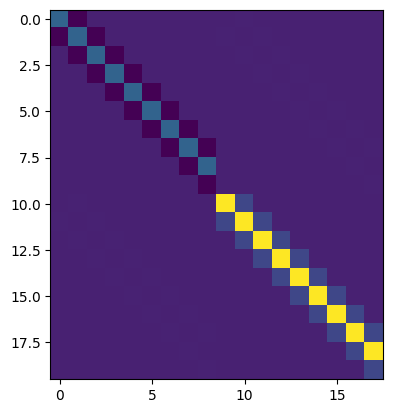

In [54]:
plt.imshow(K.to_dense())

In [24]:
torch.set_printoptions(precision=4, sci_mode=False)
K_rbf

tensor([[    1.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000],
        [    0.0000,     1.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     1.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     1.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     1.0000,     0.0000,
             0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     1.0000,
             0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             1.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     1.000

In [142]:
x1 = x
x2 = x[0:9]

batch_shape = x1.shape[:-2]
n_batch_dims = len(batch_shape)
n1, d = x1.shape[-2:]
# d must be same
n2 = x2.shape[-2]

x1_ = x1.div(lengthscale)
x2_ = x2.div(lengthscale)

outer = x1_.view(*batch_shape, n1, 1, d) - x2_.view(*batch_shape, 1, n2, d)
outer = outer / lengthscale.unsqueeze(-2)
outer = torch.transpose(outer, -1, -2).contiguous()
outer.shape

outer1.repeat([*([1] * n_batch_dims), d, 1])

tensor([[ 0.00,  0.00, -0.44, -1.11, -0.89, -2.22, -1.33, -3.33, -1.78, -4.44,
         -2.22, -5.56, -2.67, -6.67, -3.11, -7.78, -3.56, -8.89],
        [ 0.44,  1.11,  0.00,  0.00, -0.44, -1.11, -0.89, -2.22, -1.33, -3.33,
         -1.78, -4.44, -2.22, -5.56, -2.67, -6.67, -3.11, -7.78],
        [ 0.89,  2.22,  0.44,  1.11,  0.00,  0.00, -0.44, -1.11, -0.89, -2.22,
         -1.33, -3.33, -1.78, -4.44, -2.22, -5.56, -2.67, -6.67],
        [ 1.33,  3.33,  0.89,  2.22,  0.44,  1.11,  0.00,  0.00, -0.44, -1.11,
         -0.89, -2.22, -1.33, -3.33, -1.78, -4.44, -2.22, -5.56],
        [ 1.78,  4.44,  1.33,  3.33,  0.89,  2.22,  0.44,  1.11,  0.00,  0.00,
         -0.44, -1.11, -0.89, -2.22, -1.33, -3.33, -1.78, -4.44],
        [ 2.22,  5.56,  1.78,  4.44,  1.33,  3.33,  0.89,  2.22,  0.44,  1.11,
          0.00,  0.00, -0.44, -1.11, -0.89, -2.22, -1.33, -3.33],
        [ 2.67,  6.67,  2.22,  5.56,  1.78,  4.44,  1.33,  3.33,  0.89,  2.22,
          0.44,  1.11,  0.00,  0.00, -0.44, -1.11, 

In [136]:
x2_

tensor([[ 0.00, 10.00],
        [ 0.22, 20.00],
        [ 0.44, 30.00],
        [ 0.67, 40.00],
        [ 0.89, 50.00],
        [ 1.11, 60.00],
        [ 1.33, 70.00],
        [ 1.56, 80.00],
        [ 1.78, 90.00]])

In [127]:
K_11.repeat([*([1] * n_batch_dims), d, d]).shape

torch.Size([20, 18])

In [114]:
torch.ones(n1, n2, device=x1.device, dtype=x1.dtype).repeat(*batch_shape, 1, 1).shape

torch.Size([10, 9])

In [111]:
torch.eye(d, d, device=x1.device, dtype=x1.dtype).repeat(*batch_shape, 1, 1)

tensor([[1., 0.],
        [0., 1.]])

In [103]:
outer1 = outer.view(*batch_shape, n1, n2 * d)
outer1.shape

torch.Size([10, 18])

In [ ]:
    batch_shape = x1.shape[:-2]
        n_batch_dims = len(batch_shape)
        n1, d = x1.shape[-2:]
        n2 = x2.shape[-2]

        if not diag:
            K = torch.zeros(*batch_shape, n1 * (d + 1), n2 * (d + 1), device=x1.device, dtype=x1.dtype)

            # Scale the inputs by the lengthscale (for stability)
            x1_ = x1.div(self.lengthscale)
            x2_ = x2.div(self.lengthscale)

            # Form all possible rank-1 products for the gradient and Hessian blocks
            outer = x1_.view(*batch_shape, n1, 1, d) - x2_.view(*batch_shape, 1, n2, d)
            outer = outer / self.lengthscale.unsqueeze(-2)
            outer = torch.transpose(outer, -1, -2).contiguous()

            # 1) Kernel block
            diff = self.covar_dist(x1_, x2_, square_dist=True, **params)
            K_11 = postprocess_rbf(diff)
            K[..., :n1, :n2] = K_11

            # 2) First gradient block
            outer1 = outer.view(*batch_shape, n1, n2 * d)
            K[..., :n1, n2:] = outer1 * K_11.repeat([*([1] * (n_batch_dims + 1)), d])

            # 3) Second gradient block
            outer2 = outer.transpose(-1, -3).reshape(*batch_shape, n2, n1 * d)
            outer2 = outer2.transpose(-1, -2)
            K[..., n1:, :n2] = -outer2 * K_11.repeat([*([1] * n_batch_dims), d, 1])

            # 4) Hessian block
            outer3 = outer1.repeat([*([1] * n_batch_dims), d, 1]) * outer2.repeat([*([1] * (n_batch_dims + 1)), d])
            kp = KroneckerProductLinearOperator(
                torch.eye(d, d, device=x1.device, dtype=x1.dtype).repeat(*batch_shape, 1, 1) / self.lengthscale.pow(2),
                torch.ones(n1, n2, device=x1.device, dtype=x1.dtype).repeat(*batch_shape, 1, 1),
            )
            chain_rule = kp.to_dense() - outer3
            K[..., n1:, n2:] = chain_rule * K_11.repeat([*([1] * n_batch_dims), d, d])

            # Symmetrize for stability
            if n1 == n2 and torch.eq(x1, x2).all():
                K = 0.5 * (K.transpose(-1, -2) + K)

            # Apply a perfect shuffle permutation to match the MutiTask ordering
            pi1 = torch.arange(n1 * (d + 1)).view(d + 1, n1).t().reshape((n1 * (d + 1)))
            pi2 = torch.arange(n2 * (d + 1)).view(d + 1, n2).t().reshape((n2 * (d + 1)))
            K = K[..., pi1, :][..., :, pi2]

            return K

In [78]:
from gpytorch_models import dfGP